In [89]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

from matplotlib import pyplot as plt

# Uploading the Dataset

In [90]:
data_gen = ImageDataGenerator(rescale=1./255)

In [91]:
dataset_path = "D:\\Work\\My work\\Sem 3 research papers\\Potato leaf disease\\temp_data"

In [92]:
train_dataset = data_gen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    class_mode='binary'
)

Found 30 images belonging to 3 classes.


In [93]:
for i in range(len(train_dataset)):
    batch = train_dataset[i]
    train_images, train_labels = batch

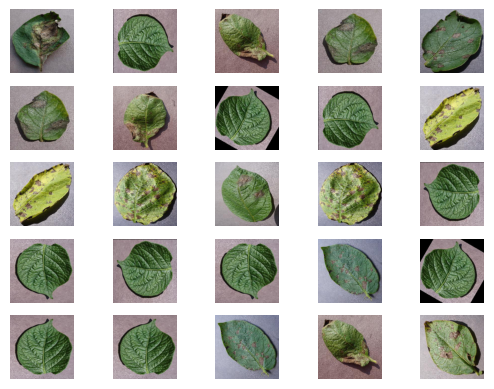

In [95]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(train_images[i])
plt.show()

# Defining the discriminator 

In [96]:
def define_discriminator(in_shape=(256,256,3)):
    model = Sequential()
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #128x128x128
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #64x64x128
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten()) #shape of 8192
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) #shape of 1

    return model

In [97]:
test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu_128 (LeakyReLU  (None, 128, 128, 128)     0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_129 (LeakyReLU  (None, 64, 64, 128)       0         
 )                                                               
                                                                 
 conv2d_65 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_130 (LeakyReLU  (None, 32, 32, 128)     

# Defining the Generator

In [98]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
    model = Sequential()
    # We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    
    n_nodes = 128 * 8 * 8  #8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
    
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #64x64x128
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #128x128x128
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 256x256
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #256x256x128
    model.add(LeakyReLU(alpha=0.2))
    
    # generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #256x256x3
    return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

In [99]:
test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 8192)              827392    
                                                                 
 leaky_re_lu_133 (LeakyReLU  (None, 8192)              0         
 )                                                               
                                                                 
 reshape_13 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_65 (Conv2  (None, 16, 16, 128)       262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_134 (LeakyReLU  (None, 16, 16, 128)       0         
 )                                                               
                                                     

# Defining the combined GAN model

In [100]:
def define_gan(generator, discriminator):
    discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
    
    # connect generator and discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

# Converting the dataset to appropriate range

In [101]:

# Convert to float and scale.
X = train_images.astype('float32')

# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.


# Generate 50% real images and 50% fake images for training 

### Generate real images 

In [102]:
def generate_real_samples(dataset, n_samples):
    
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    X = dataset[ix]
    
    # generate class labels and assign to y
    y = ones((n_samples, 1)) ##Label=1 indicating they are real
    return X, y

### Generate the noise from which fake images will be generated

In [103]:
def generate_latent_points(latent_dim, n_samples): #both can be used
    
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [104]:
def generate_latent_points(latent_dim, n_samples): #use this or previous one
    
    x_input = tf.random.normal([n_samples, latent_dim])
    return x_input

### Generate fake images

In [105]:
def generate_fake_samples(generator, latent_dim, n_samples):
    
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # predict using generator to generate fake samples. 
    X = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake. 
    y = zeros((n_samples, 1))  #Label=0 indicating they are fake
    return X, y

# Defining the Training Function

In [106]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=30):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
    print(bat_per_epo, half_batch)
    # manually enumerate epochs and bacthes. 
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
            #Research showed that separate training is more effective. 
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            
            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
            
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 

            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples as valid (ones)
            #This is where the generator is trying to trick discriminator into believing the generated image is true (hence value of 1 for y)
            y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
            # Train the generator with latent_dim as x and 1 as y. 
            # Again, 1 as the output as it is adversarial and if generator did a great job of folling the discriminator then the output would be 1 (true)
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # Print losses on this batch
            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
            
            # save the generator model
    return g_model

# Training the GAN model

In [107]:
latent_dim = 100
n_epochs = 2 #change accordingly 

# create the discriminator
discriminator = define_discriminator()
opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


# create the generator
generator = define_generator(latent_dim)

# create the gan
gan_model = define_gan(generator, discriminator)
opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)
gan_model.compile(loss='binary_crossentropy', optimizer=opt)

# load image data
dataset = X
n_batch=X.shape[0]

# train model
final_generator = train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs, n_batch)

1 15
1/1 [==============================] - 10s 10s/step
Epoch>1, Batch 1/1, d1=0.633, d2=0.695 g=0.692
1/1 [==============================] - 11s 11s/step
Epoch>2, Batch 1/1, d1=0.433, d2=0.696 g=0.692


# Using the generator of GAN model to create images 

In [108]:
import numpy as np

latent_points = generate_latent_points(100, 25)  

X = final_generator.predict(latent_points)

1/1 [==============================] - 16s 16s/step


In [109]:
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

In [110]:
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()